# Dataset preparation

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

from pyarrow import Table
from pandas import DataFrame, api, Int64Dtype
from pandas.core.dtypes import common as com
import sys
sys.path.append('..')
from utils.preprocess import NDF

def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

##################################
# EDIT to specify the model name #
##################################
model_name = "malware_cesnet"     
##################################

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312.parquet',
    '../feature-extraction/floor/umbrella_benign_FINISHED.parquet'
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/phishing_final_2024.parquet',
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "phishing"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]

malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Merge them together and create NDF

# Store them for future use (e.g. creating NDF)
df_benign.to_parquet('temp/benign_merged.parquet')
df_malicious.to_parquet('temp/malicious_merged.parquet')

from utils.preprocess import NDF
input_data = {
    'benign': 'temp/benign_merged.parquet',
    'malign': 'temp/malicious_merged.parquet'
}
ndf_dataset = NDF("phishing", True, input_data=input_data, one_line_processing=False)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2024-05-25 23:13:43,350 - utils.preprocess - INFO - Benign dataset path: temp/benign_merged.parquet
2024-05-25 23:13:43,351 - utils.preprocess - INFO - Malign dataset path: temp/malicious_merged.parquet
2024-05-25 23:13:43,902 - utils.preprocess - INFO - Number of records in combined dataset: 1001591
2024-05-25 23:14:38,207 - utils.preprocess - INFO - Decision tree model saved to models/decision_tree_model.joblib
2024-05-25 23:14:39,292 - utils.preprocess - INFO - New feature 'dtree_prob' created from decision tree predictions.
2024-05-25 23:14:41,519 - utils.preprocess - INFO - Decision Tree Train Accuracy: 0.97
2024-05-25 23:14:41,519 - utils.preprocess - INFO - Decision Tree Test Accuracy: 0.96
2024-05-25 23:16:47,483 - utils.preprocess - INFO - Decision Tree Cross-Validation Scores: [0.95639542 0.95611087 0.95615267]
2024-05-25 23:16:47,728 - utils.preprocess - I

2024-05-25 23:17:32,651 - utils.preprocess - INFO - Outliers removed from rdap_registrant_name_len: 113 rows
2024-05-25 23:17:33,165 - utils.preprocess - INFO - Outliers removed from rdap_admin_name_len: 4198 rows
2024-05-25 23:17:33,432 - utils.preprocess - INFO - Outliers removed from rdap_admin_name_entropy: 3933 rows
2024-05-25 23:17:33,698 - utils.preprocess - INFO - Outliers removed from rdap_admin_email_len: 2830 rows
2024-05-25 23:17:34,215 - utils.preprocess - INFO - Outliers removed from rdap_ip_v4_count: 13 rows
2024-05-25 23:17:34,492 - utils.preprocess - INFO - Outliers removed from rdap_ip_v6_count: 7 rows
2024-05-25 23:17:35,776 - utils.preprocess - INFO - Outliers removed from rdap_ip_avg_admin_name_len: 170 rows
2024-05-25 23:17:36,825 - utils.preprocess - INFO - Completed outlier removal.
2024-05-25 23:17:38,759 - utils.preprocess - INFO - Applying StandardScaler scaling to the features.
2024-05-25 23:17:40,428 - utils.preprocess - INFO - Scaler saved to models/scaler


Dataset Subset:
Name: dataset_temp/maliciousmerged_2024-05-25.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   3.125064  -1.004527  -0.424121  -0.516387  -0.735418  -0.439875   
1  -0.319993   0.864734  -0.424121   3.062241   1.798996   0.610254   
2  -0.319993  -1.004527  -0.424121  -0.516387  -0.735418  -0.439875   
3  -0.319993  -1.004527  -0.424121  -0.516387  -0.735418  -0.439875   
4  -0.319993  -1.004527  -0.424121  -0.516387  -0.735418  -0.439875   
5  -0.319993   0.864734  -0.424121  -0.516387  -0.735418  -0.439875   
6  -0.319993  -0.069896  -0.424121   0.199339   1.798996   0.085189   
7  -0.319993  -0.069896  -0.424121   0.199339   1.165393   1.135319   
8  -0.319993   3.668627   5.077100  -0.516387  -0.735418  -0.439875   
9  -0.319993  -0.069896  -0.424121  -0.516387  -0.735418  -0.439875   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_161  Feature_162  \
0  -0.851905   1.982463  -0.294592  -0.247121  ...    -0.

In [8]:
# Convert the unique feature names to a list
#feature_names_list = ndf_dataset['feature_names'].unique().tolist()

# Print each feature name individually
#for feature in feature_names_list:
#    print(feature)


# Model validation function

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from kneed import KneeLocator

def ValidateModel_advanced(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    
    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)

    # Plotting ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Model-specific evaluations
    if isinstance(model, (XGBClassifier, LGBMClassifier)):
        
        if isinstance(model, (XGBClassifier)):
            results = model.evals_result()
        elif isinstance(model, (LGBMClassifier)):
            results = model.evals_result_

        training_key = 'training' if isinstance(model, LGBMClassifier) else 'validation_0'
        validation_key = 'valid_1' if isinstance(model, LGBMClassifier) else 'validation_1'
        
        print("Training metrics:", results[training_key].keys())
        print("Validation metrics:", results[validation_key].keys())

        trees = len(results[validation_key]['binary_logloss']) if isinstance(model, LGBMClassifier) else len(results[validation_key]['logloss'])
        x_axis = range(0, trees)

        def plot_metric(metric):
            plt.rcParams["figure.dpi"] = 300

            # Plot metric curves
            plt.plot(x_axis, results[training_key][metric], label='Training set')
            plt.plot(x_axis, results[validation_key][metric], label='Validation set')

            # Detect elbow using Kneedle algorithm
            kn = KneeLocator(x_axis, results[validation_key][metric], curve='convex', direction='decreasing')
            if kn.knee:
                plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))

            plt.legend()
            mnames = {'binary_logloss': 'Log Loss', 'auc': 'AUC'}
            mname = mnames.get(metric, metric)
            plt.ylabel(mname)
            plt.xlabel('Number of trees')
            plt.title(f'{type(model).__name__} {mname}')
            plt.show()

        if isinstance(model, LGBMClassifier):
            plot_metric('binary_logloss')
        elif isinstance(model, XGBClassifier):
            plot_metric('logloss')
            
        plot_metric('auc')
        
    elif isinstance(model, (RandomForestClassifier, AdaBoostClassifier)):
        # For RandomForest and AdaBoost, additional model-specific evaluations can be added here
        pass
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot

# NDF-based LightGBM

In [4]:
# Check if the NDF contains corresponding number of classes

# Assuming ndf_dataset is a DataFrame with 'features' and 'labels' columns
X = np.array(ndf_dataset['features'].tolist())
Y = np.array(ndf_dataset['labels'].tolist())

# Check unique values in labels
unique_labels = np.unique(Y)
print(f"Unique labels: {unique_labels}")

# Ensure binary classification
assert len(unique_labels) == 2, "The problem is not binary classification."

Unique labels: [0. 1.]


In [5]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module="sklearn")

X_train, X_test, Y_train, Y_test = train_test_split(  
  np.array(ndf_dataset['features']),
  np.array(ndf_dataset['labels']),
  test_size=0.2,
  random_state=42
)

## LightGBM NDF-based model Training

In [6]:
import joblib
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM parameters
params = {
    "objective": "binary",  # binary classification
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
    "num_leaves": 59,
    "max_depth": 17,
    "learning_rate": 0.15,
    "objective": "binary",
    "min_child_samples": 27,
    "colsample_bytree": 0.9,
    "reg_lambda": 0.11,
    "scale_pos_weight": 6.28, # default: 1.0
    "subsample_for_bin": 240000,
    "random_state": 7,
}


model = lgb.LGBMClassifier(**params, metric=['error', 'binary_logloss', 'auc'])

# at last, train the model
eval_set = [(X_train, Y_train), (X_test, Y_test)]
_ = model.fit(X_train, Y_train, eval_set=eval_set)

# Save the model to a file
joblib.dump(model, 'models/phishing_lgbm_model.joblib')

[LightGBM] [Info] Number of positive: 128368, number of negative: 600483
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15136
[LightGBM] [Info] Number of data points in the train set: 728851, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176124 -> initscore=-1.542833
[LightGBM] [Info] Start training from score -1.542833


['models/phishing_lgbm_model.joblib']

## LightGBM NDF-based model Validation

              precision    recall  f1-score   support

         0.0     0.9957    0.9967    0.9962    149942
         1.0     0.9846    0.9800    0.9822     32271

    accuracy                         0.9937    182213
   macro avg     0.9901    0.9883    0.9892    182213
weighted avg     0.9937    0.9937    0.9937    182213

Confusion Matrix:
TN: 149446 FP: 496 FN: 647 TP: 31624


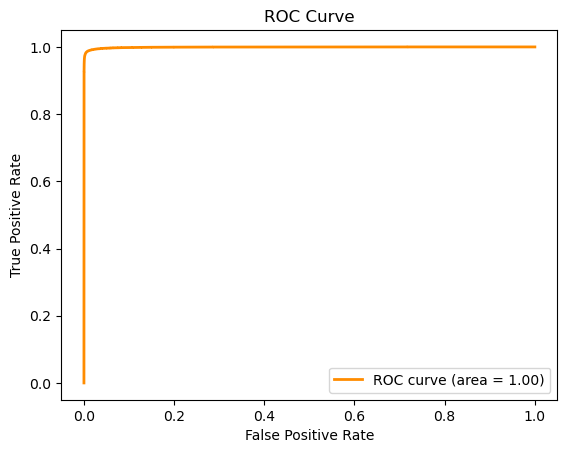

Training metrics: odict_keys(['binary_logloss', 'auc'])
Validation metrics: odict_keys(['binary_logloss', 'auc'])


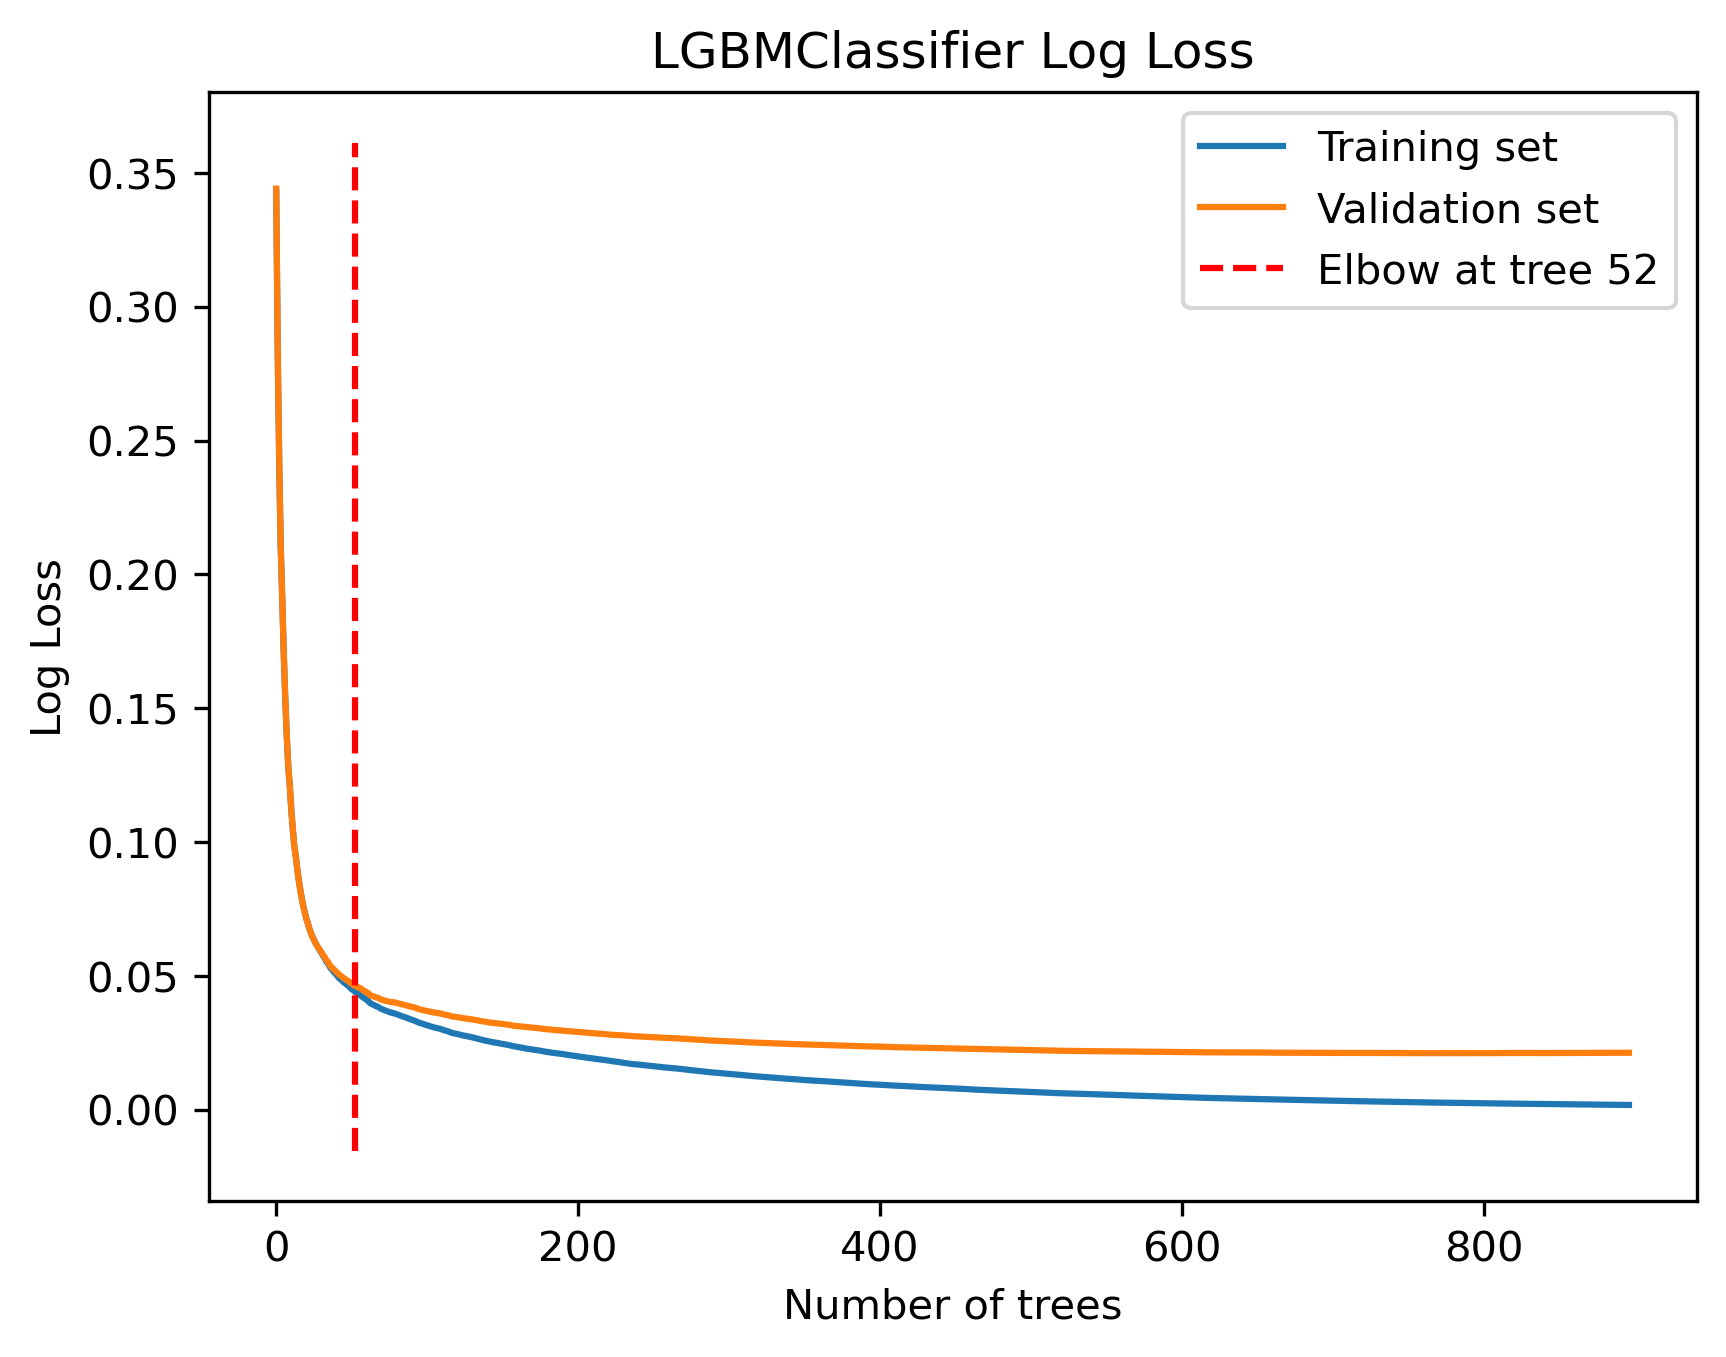

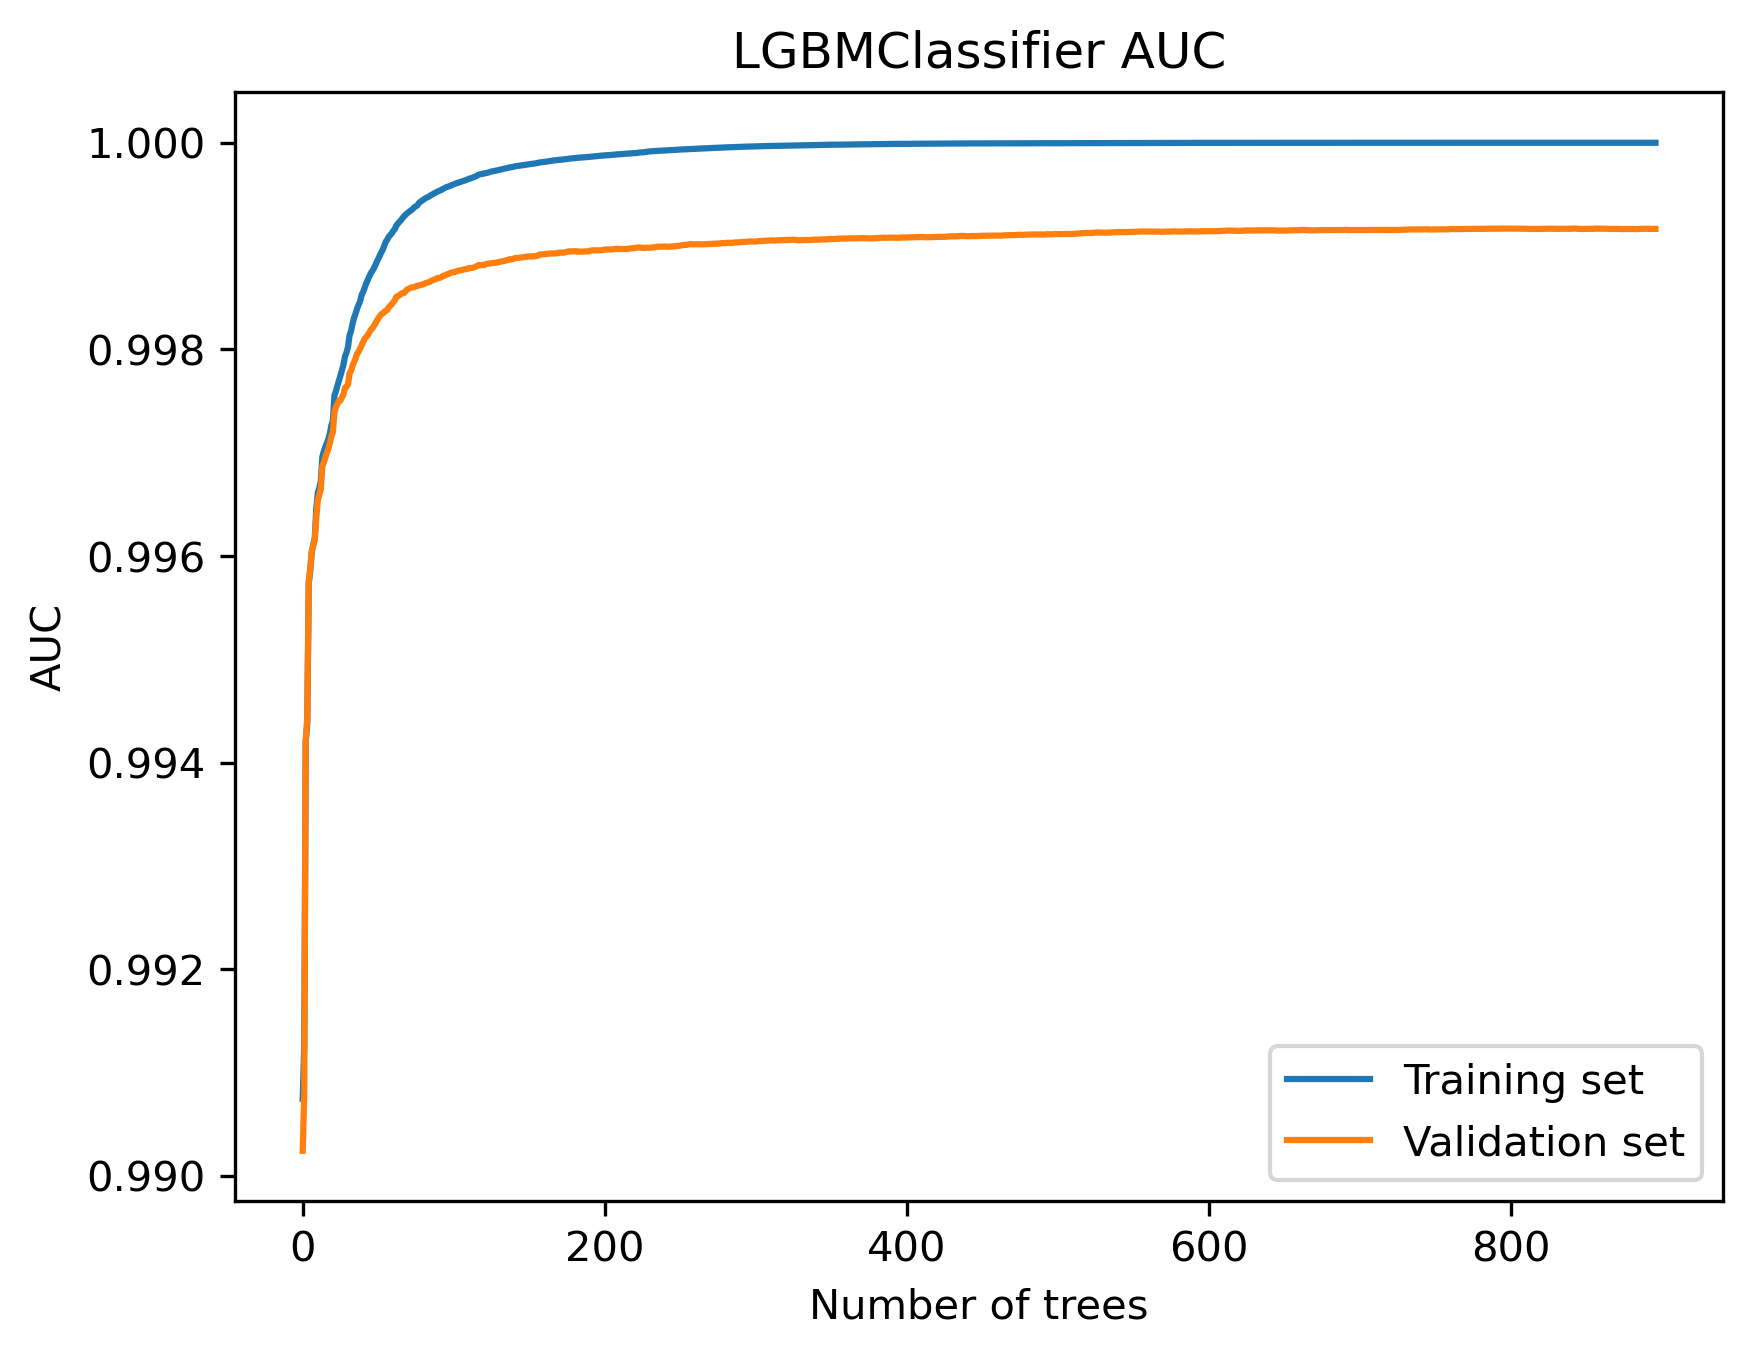

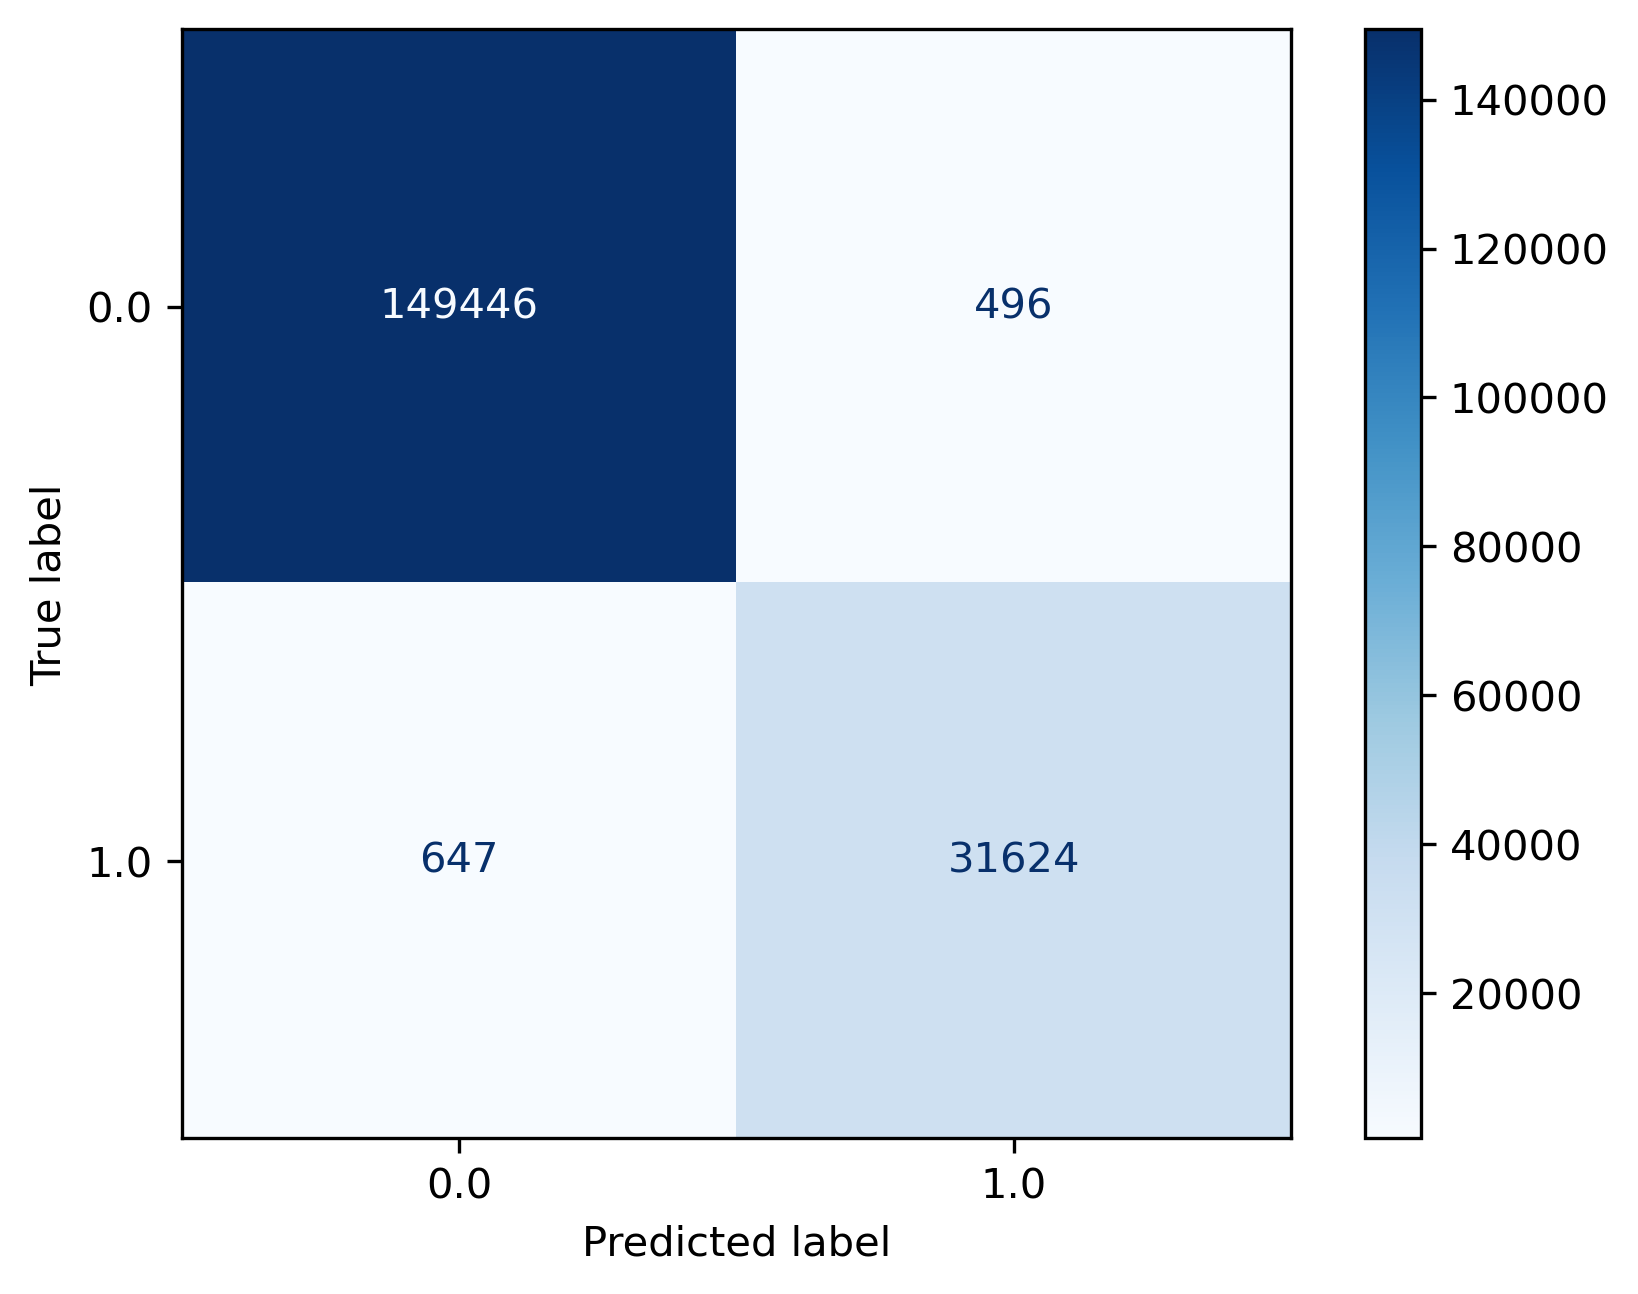

In [7]:
ValidateModel_advanced(X_test, Y_test, model)